# Using RoBERTa for Similarity Detection in English Language

## Task 0: Import Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Task 1: Load and Preprocess the Data

In [2]:
data = []

for i in range(100):
    ## Read original file
    original = open('/usercode/Dataset/' + str(i+1) + '-original.txt', 'r')
    original_text = original.read()

    ## Read candidate file
    candidate = open('/usercode/Dataset/' + str(i+1) + '-paraphrase.txt', 'r')
    candidate_text = candidate.read()

    ## Read metadata file
    with open('/usercode/Dataset/' + str(i+1) + '-metadata.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(':')
            if key == 'Paraphrase':
                verdict = value.strip()
    
    sample = [original_text, candidate_text, verdict]
    data.append([s.replace('\n', ' ') for s in sample])


# create a 2D array
my_array = np.array(data)

# convert the array into a dataframe
df = pd.DataFrame(my_array)

df.columns = ["source", "target", "label"]

# Define a dictionary to map day values to integers
verdict_dict = {'Yes': 1, 'No': 0}

# Replace day values with integers
df['label'] = df['label'].map(verdict_dict)

print(df.head)

<bound method NDFrame.head of                                                source   
0   M. Comte would not advise so irrational a proc...  \
1   Without enumerating all the modern authors who...   
2   Therefore, a person should search his actions ...   
3   "I have heard many accounts of him," said Emil...   
4   "I have heard many accounts of him," said Emil...   
..                                                ...   
95  We have many processes by which the form of th...   
96   It was the custom in Elizabethan times to wea...   
97   It was the custom in Elizabethan times to wea...   
98  The object of the adjustable stroke is to dimi...   
99  Thad, of course. And, Bill, we're going to get...   

                                               target  label  
0   Even M. Comte would spurn such irrational reas...      1  
1   Just without specifying the current writers wh...      1  
2   As such, a person should analyze what he did a...      1  
3   Emily said, "I have heard man

## Task 2: Split the Dataset

In [3]:
# Split the dataset into train, validtion and test sets
train_df = df[:60]
val_df = df[60:80]
test_df = df[80:]

## Task 3: Tokenize Datasets

In [4]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_df['source'].tolist(), train_df['target'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['source'].tolist(), val_df['target'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['source'].tolist(), test_df['target'].tolist(), truncation=True, padding=True)

## Task 4: Generate Tensors

In [5]:
class ParaphraseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ParaphraseDataset(train_encodings, train_df['label'].tolist())
val_dataset = ParaphraseDataset(val_encodings, val_df['label'].tolist())
test_dataset = ParaphraseDataset(test_encodings, test_df['label'].tolist())

## Task 5: Load Pre-trained RoBERTa Model and Select Device

In [6]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Task 6: Prepare Training Arguments and Create Trainer Object

In [7]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=0,
    weight_decay=0.01,
    learning_rate=5e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    save_total_limit=3,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=lambda data: {'input_ids': torch.stack([item['input_ids'] for item in data]),
                                'attention_mask': torch.stack([item['attention_mask'] for item in data]),
                                'labels': torch.tensor([item['labels'] for item in data])},
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1))}
)

## Task 7: Train the Model

In [8]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
10,0.577400,0.795820,0.600000
20,0.422300,0.876314,0.600000


TrainOutput(global_step=20, training_loss=0.4998456001281738, metrics={'train_runtime': 454.5698, 'train_samples_per_second': 0.66, 'train_steps_per_second': 0.044, 'total_flos': 24974994708000.0, 'train_loss': 0.4998456001281738, 'epoch': 5.0})

## Task 8: Test the Model and Calculate Accuracy

In [9]:
# Get the predicted labels for the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels for the test dataset
true_labels = test_df['label'].tolist()

print('Accuracy:', accuracy_score(true_labels, predicted_labels))

Accuracy: 0.65


## Task 9: Compute and Display Confusion Matrix

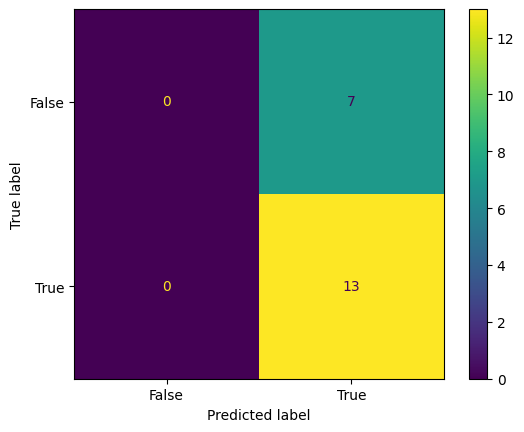

In [10]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()